### dPCA 

dPCA looks to be essentially a form of [CSP](https://hal.archives-ouvertes.fr/hal-00602686/document), and it doesn’t seem fair to call dPCA unsupervised, as it requires known trials and time alignment. CSP doesnt require time

Because we want to take somewhat freeform data to build a decoder, we need a method that allows the extraction of “events” from the data which can then be used for alignment and marginalization. If I were to say, “do 10 trials of finger wiggle X”, averaging over those trials wouldn’t necessarily cancel noise since they aren't timelocked to a known onset. For each output X, for dPCA I need something that I can use to align data so that when I average over stimuli (but not over time), activity isn't just washed out. 

Ultimately we want to get a single decoder that allows us to disambiguate modes in the data. To do this it seems like if we simply put our recordings into buckets, we can split up the reduction to per-bucket, and combine them to get a single decoder?

I think our case is unique because we actually don't care that much about the accuracy of classifying the movements after the fact. We actually care more than the components we pull from the data are maximally separated up to what we feed in. What's the best basis for this data according to the criterion that each basis vector captures the most variance while remaining as far away from the other vectors as possible. This seems like what NMF is doing, but if we can help it by specifiying some rough directions using dPCA then why not. 

### make some fake data

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import analysis 
from dPCA import dPCA
from analysis import plot_biolectric

(10, 64, 2, 500)


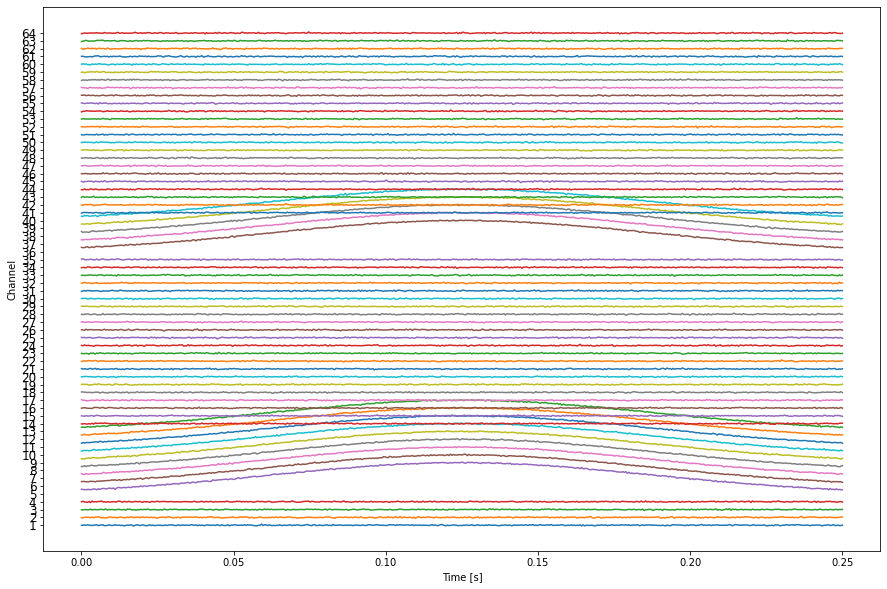

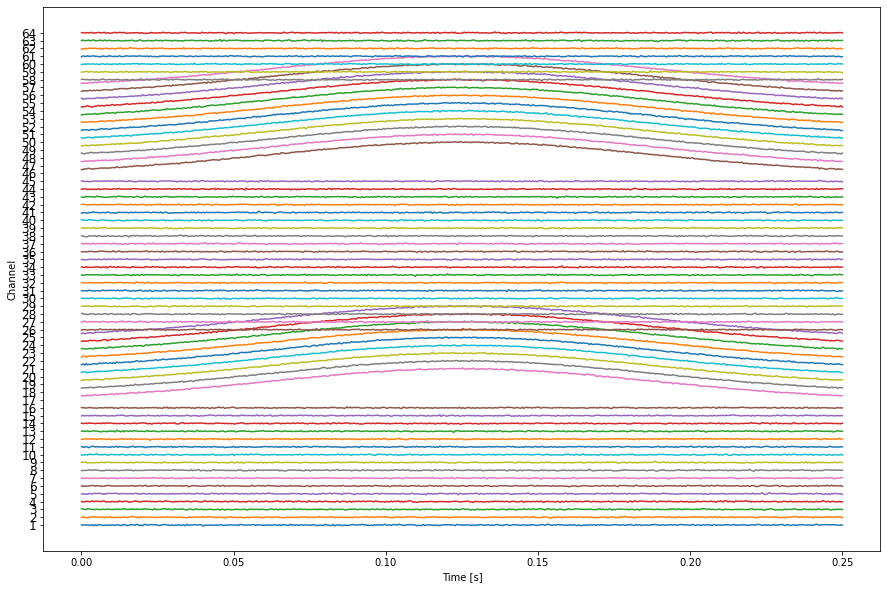

In [10]:
K = 10
N = 64
T = 500
S = 2 

# add gaussian bumps to trials 
def gaussian(x, mu=0, sig=10, amp=10, jitter=0):
    return amp*np.exp(-np.power((x - mu + np.random.normal(scale=jitter)), 2.) / (2 * np.power(sig, 2.)))

def make_fake_data(num_trials, num_channels, num_timepoints):
    num_tasks = S
    offset = 0
    trials = []
    means = [0,0]#-num_timepoints//4,num_timepoints//4]
    ranges = [list(range(4,13))+list(range(35,40)), list(range(16,25))+list(range(45,57))]
    data = np.empty(shape=(num_trials,num_channels,num_tasks,num_timepoints))
    for task_idx in range(num_tasks):
        for trial_idx in range(num_trials):
            data[trial_idx,:,task_idx,:] = np.random.normal(size=(num_channels,num_timepoints),scale=1)
            for r in ranges[task_idx]:
                data[trial_idx,r,task_idx,:] += offset + 10*gaussian(np.linspace(-num_timepoints//2,num_timepoints//2,num_timepoints), sig=num_timepoints//4, mu=means[task_idx])
    return data

data = make_fake_data(K,N,T)
print("trials, channels, tasks, timepoints")
print(data.shape)
fig = plot_biolectric(data[0,:,0,:],offset=25)
fig = plot_biolectric(data[0,:,1,:],offset=25)

In [11]:
trial_avg = data.mean(axis=0)
m = np.mean(trial_avg.reshape((N,-1)),axis=1)[:,None,None]
print(m.shape)
trial_avg -= m
print(trial_avg.shape)

(64, 1, 1)
(64, 2, 500)


In [12]:
dpca = dPCA.dPCA(labels='st',regularizer='auto')
dpca.protect = ['t']
Z = dpca.fit(trial_avg,data)

You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.
Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  4.049565169663997e-06
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.


In [26]:
print(Z.D['s'].shape)
print(Z.D['t'].shape)
print(Z.D['st'].shape)

(64, 10)
(64, 10)
(64, 10)


<ipython-input-13-e34da08fa32d>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


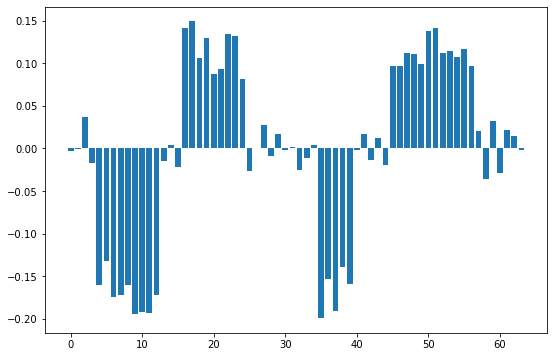

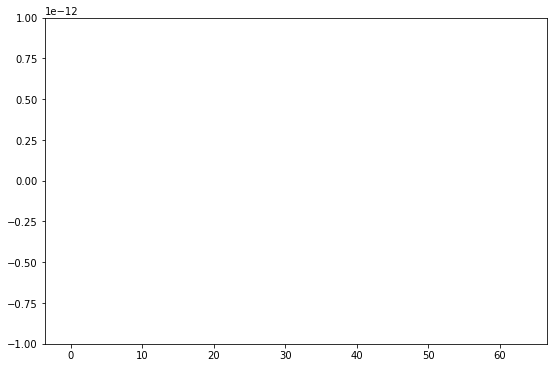

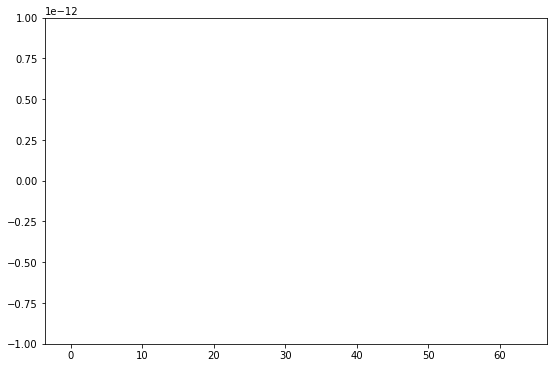

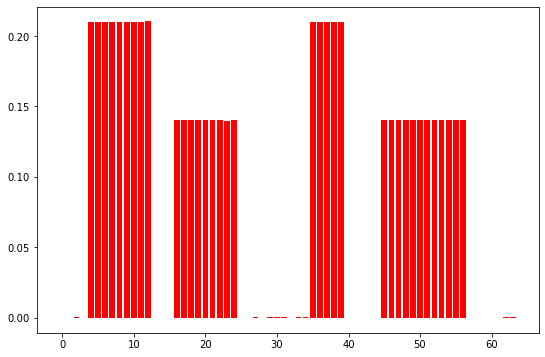

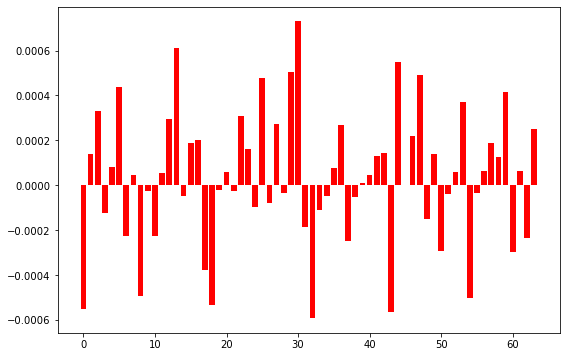

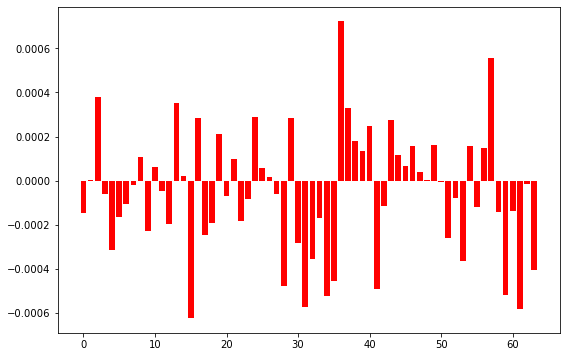

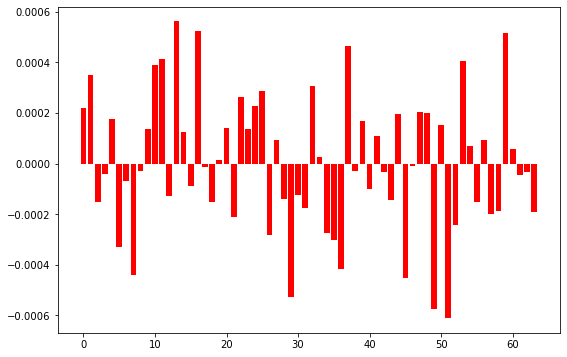

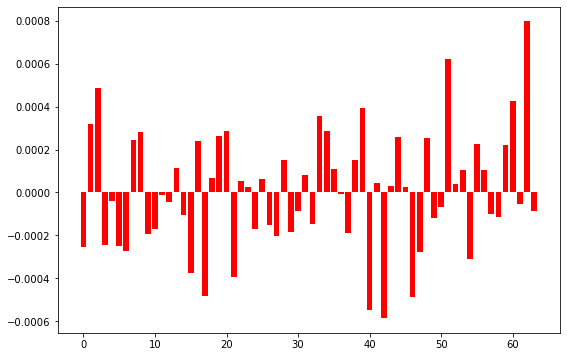

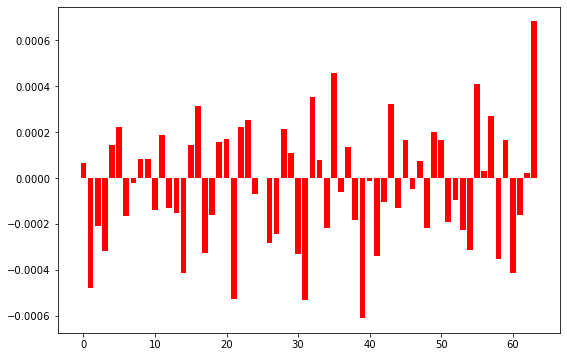

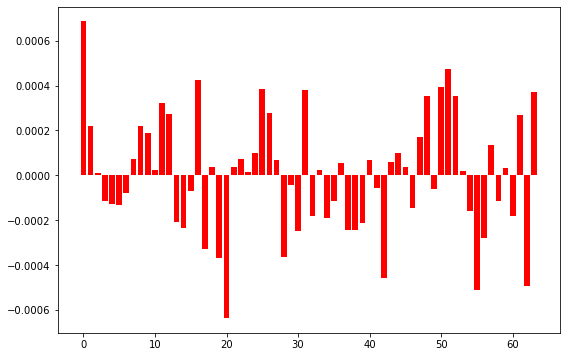

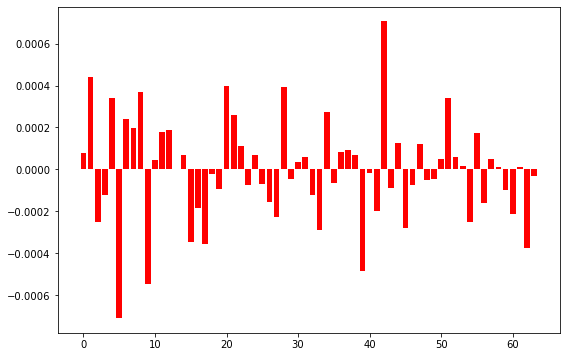

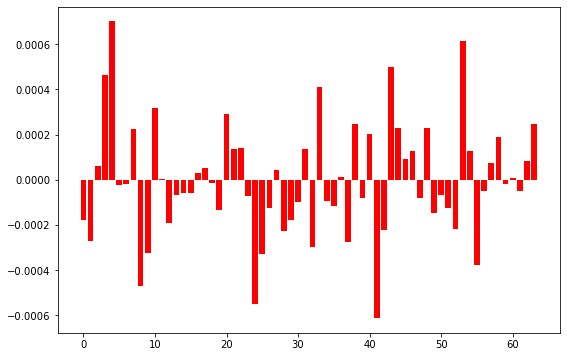

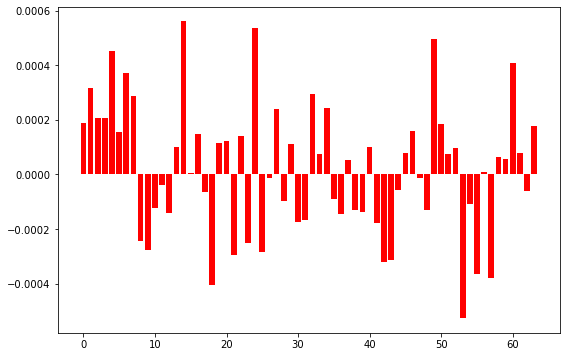

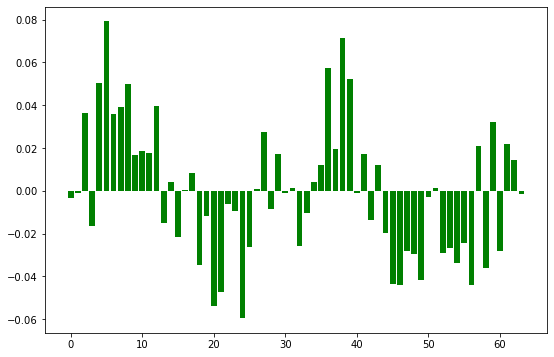

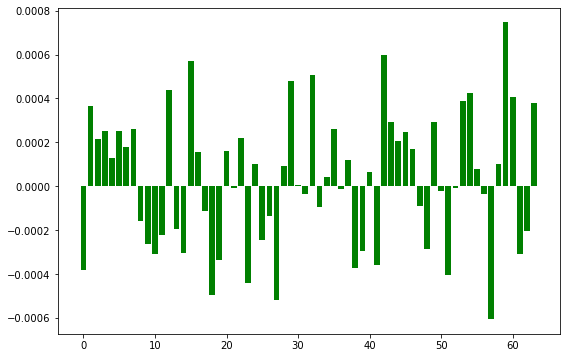

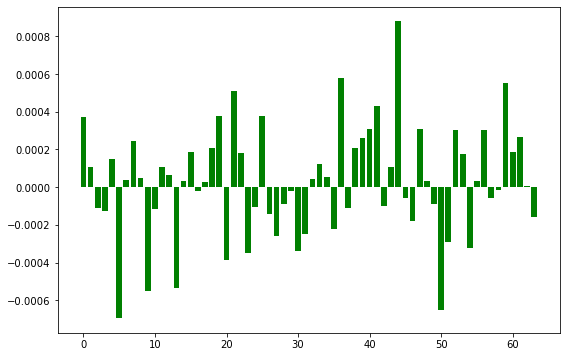

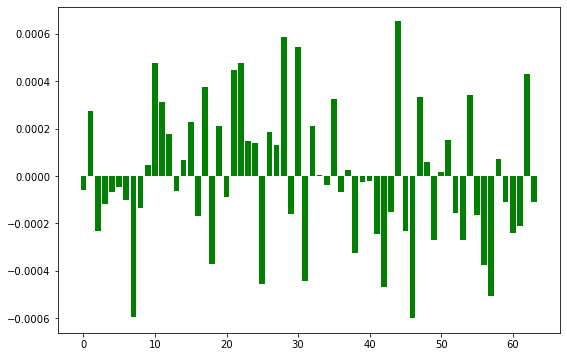

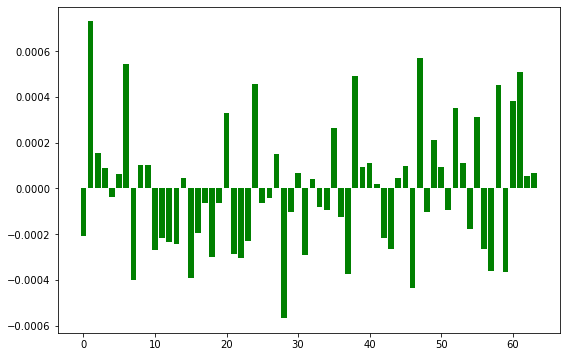

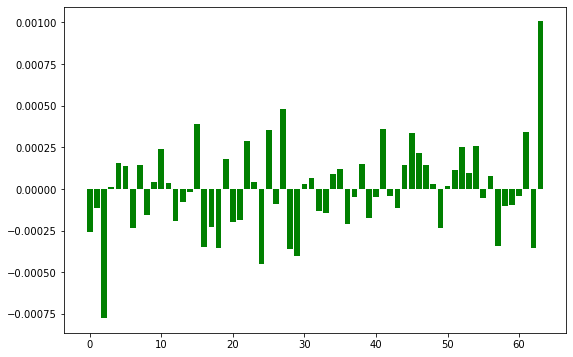

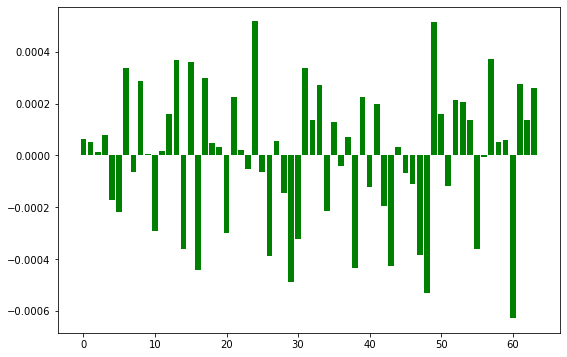

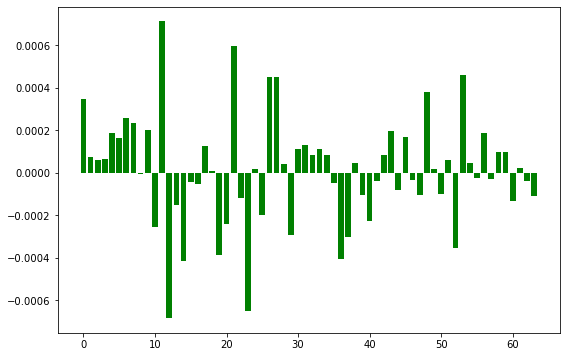

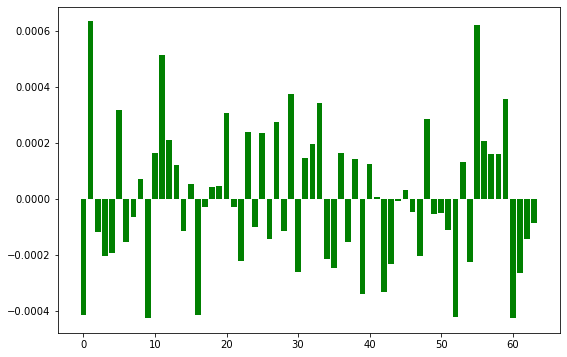

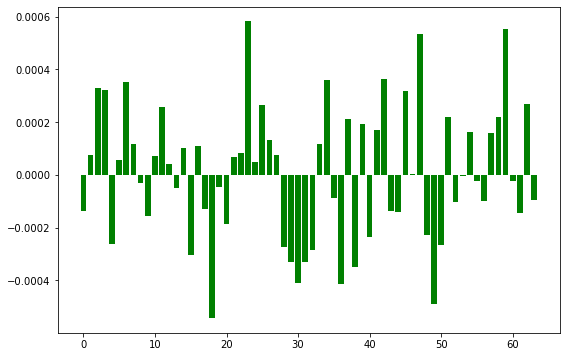

In [13]:
for i in range(3): # Z.D['s'].shape[1]):
    plt.figure()
    plt.bar(range(Z.D['s'].shape[0]),Z.D['s'][:,i])
    
for i in range(Z.D['t'].shape[1]):
    plt.figure()
    plt.bar(range(Z.D['t'].shape[0]),Z.D['t'][:,i],color='r')

for i in range(Z.D['st'].shape[1]):
    plt.figure()
    plt.bar(range(Z.D['st'].shape[0]),Z.D['st'][:,i],color='g')


In [14]:
transformed = dpca.transform(trial_avg)

(10, 2, 500)


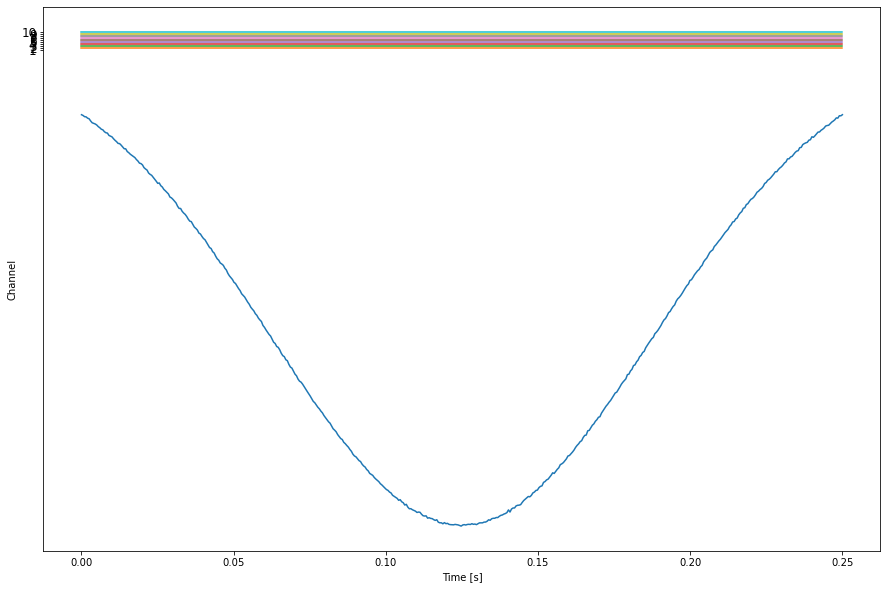

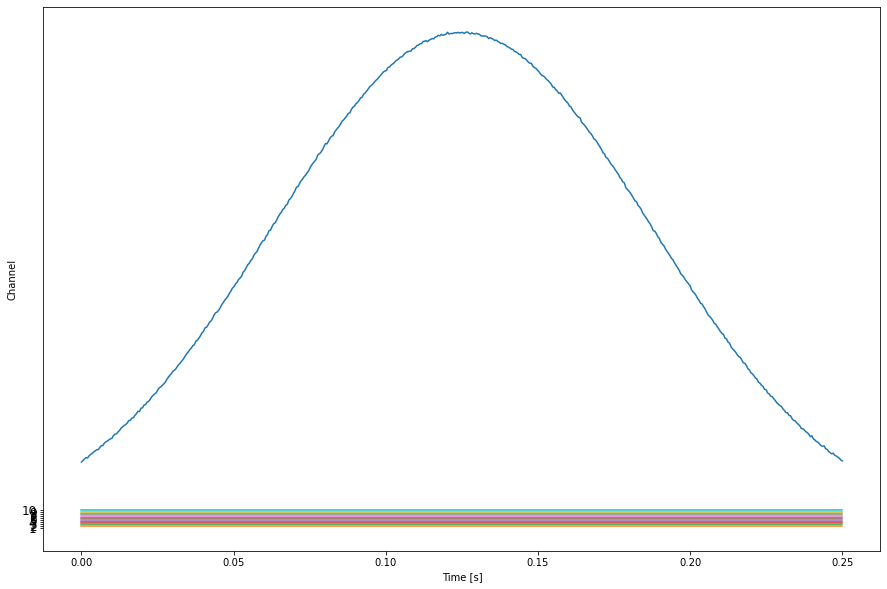

In [15]:
print(transformed['s'].shape)
for i in range(transformed['s'].shape[1]):
    fig = plot_biolectric(transformed['s'][:,i,:])

(10, 2, 500)


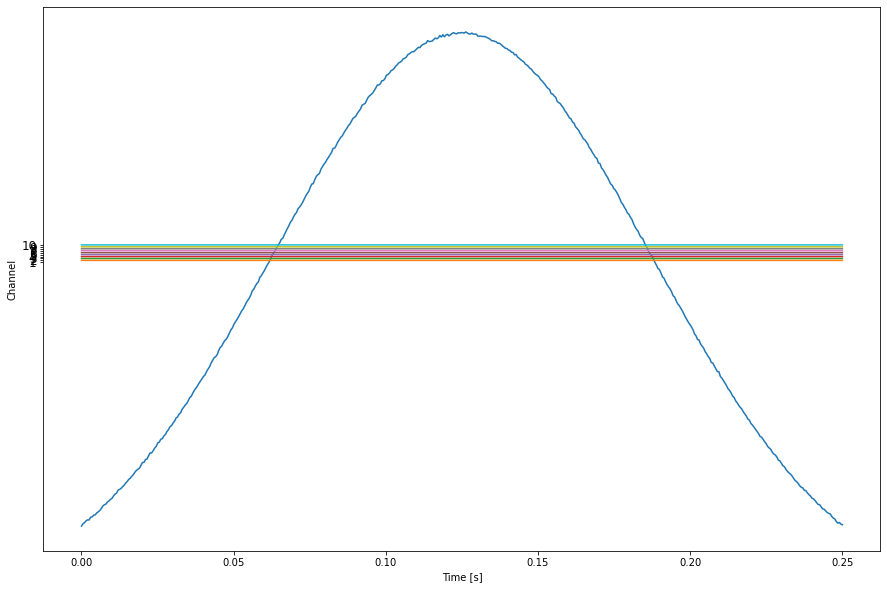

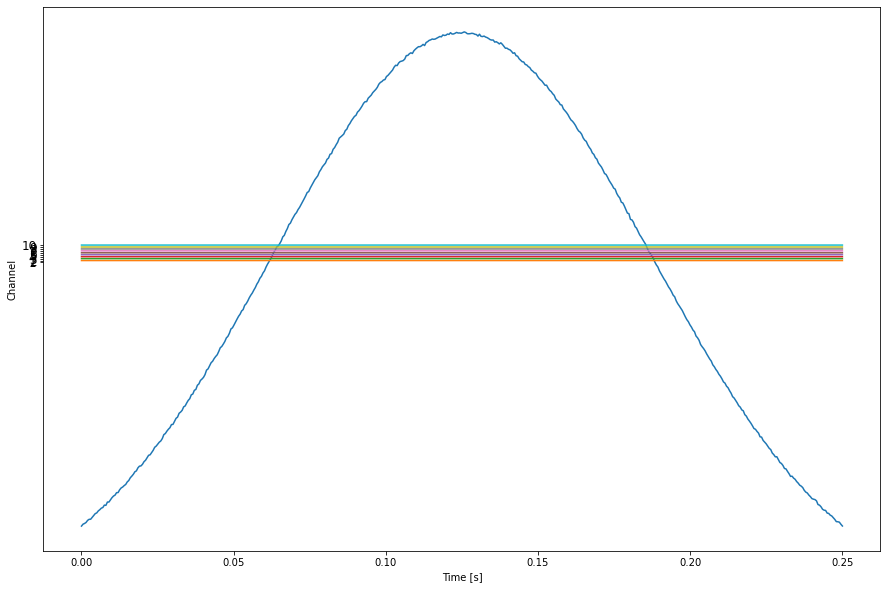

In [16]:
print(transformed['t'].shape)
for i in range(transformed['t'].shape[1]):
    plot_biolectric(transformed['t'][:,i,:])

(10, 2, 500)


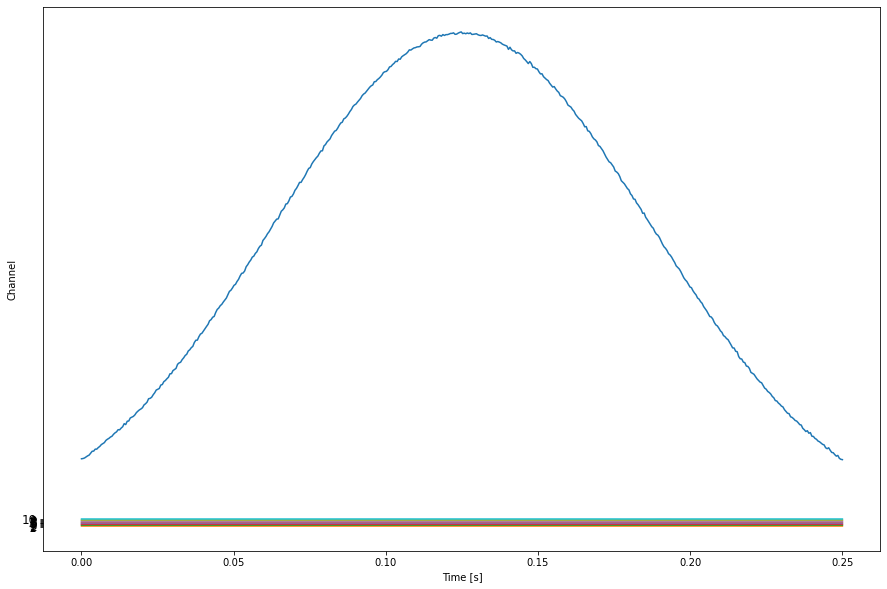

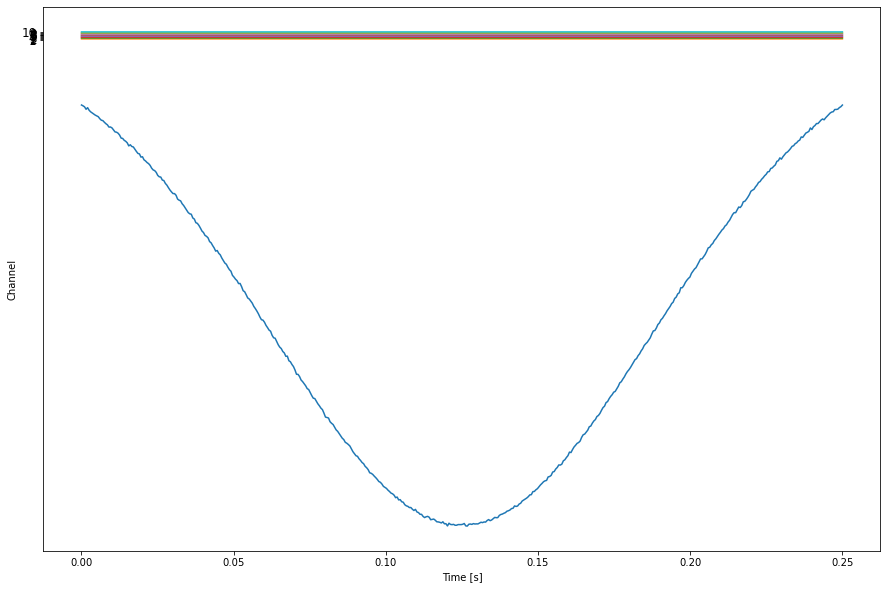

In [17]:
print(transformed['st'].shape)
for i in range(transformed['st'].shape[1]):
    plot_biolectric(transformed['st'][:,i,:],offset=0.1)